# Imports

In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# keep matplotlib interactive
# NOTE: one must reload matplotlib to change of rendering style
%matplotlib notebook
# %matplotlib inline
# use ggplot style
plt.style.use('ggplot')

# Data Description
Description of transactions

                                                

|                                       transactions.csv                                        |
|-----------------------------------------------------------------------------------------------|
| msno                   | user id  (letters, digits and special characters)                    |
| payment_method_id      | payment method   (masked)                                            |
| payment_plan_days      | length of membership plan in days                                    |
| plan_list_price        | in New Taiwan Dollar (NTD)                                           |
| actual_amount_paid     | in New Taiwan Dollar (NTD)                                           |
| is_auto_renew          | true when customer opted in renewing its subscription automatically  |
| transaction_date       | format %Y%m%d                                                        |
| membership_expire_date | format %Y%m%d                                                        |
| is_cancel              | whether or not the user canceled the membership in this transaction. |



### Transactions

In [2]:
transaction_dir = os.path.join(os.pardir, 'data', 'raw', 'transactions.csv')
df_transac = pd.read_csv(transaction_dir, index_col = 'msno', parse_dates=['transaction_date', 'membership_expire_date'])

In [3]:
df_transac.count()

payment_method_id         21547746
payment_plan_days         21547746
plan_list_price           21547746
actual_amount_paid        21547746
is_auto_renew             21547746
transaction_date          21547746
membership_expire_date    21547746
is_cancel                 21547746
dtype: int64

In [4]:
# treat payment_method_id as a category
df_transac.payment_method_id = df_transac.payment_method_id.astype('category')
# convert relevant columns to boolean
df_transac.is_auto_renew = df_transac.is_auto_renew.astype(bool)
df_transac.is_cancel = df_transac.is_cancel.astype(bool)

In [5]:
df_transac.info()

<class 'pandas.core.frame.DataFrame'>
Index: 21547746 entries, YyO+tlZtAXYXoZhNr3Vg3+dfVQvrBVGO8j1mfqe4ZHc= to oE4y2wK5E7OR8zyrCHeW02uTeI6wTwT4QTApEVBNEdM=
Data columns (total 8 columns):
payment_method_id         category
payment_plan_days         int64
plan_list_price           int64
actual_amount_paid        int64
is_auto_renew             bool
transaction_date          datetime64[ns]
membership_expire_date    datetime64[ns]
is_cancel                 bool
dtypes: bool(2), category(1), datetime64[ns](2), int64(3)
memory usage: 1.0+ GB


In [6]:
def plot_bar(df, bar_list, is_Norm=True):
    """
        Make a bar plot using dataframe df and associated columns in bar_list
        is_Norm will normalize distribution by counts
        df: pandas DataFrame
        bar_list: list of column names
    """
    # keep 2 columns and compute number of rows needed in subpots
    subrows = int(np.ceil(len(bar_list) / 2))
    discard_last_ax = bool(len(bar_list) % 2)
    
    # special case when there is only one column specified
    # then keep one figure and make it bigger
    if subrows == 1 and discard_last_ax:
        _ , ax = plt.subplots(figsize=(9,5))
        ax = [ax]
    else:
        _ , ax = plt.subplots(subrows, 2)
        ax = ax.flatten()
    for k, colname in enumerate(bar_list):
        
        # select column and make bar plot
        s_colname = df[colname]
        distrib = s_colname.value_counts(normalize = is_Norm).sort_index()*100
        distrib.plot(kind='bar', ax=ax[k], color='b')
        
        # add percent character to y tick label if plot normalized
        if is_Norm:
            # add percent on y axis labels, uses numerical value of each tick (just in case scale has changed)
#             ax[k].set_yticklabels([ '{:.0f}%'.format(l)  for l in ax[k].get_yticks()])
            pass
        else:
            ax[k].set_ylabel('Count')
                
        # reformat existing x ticklabels to integer (may not be required)
        # When numeric columns have Nans then it will show float number
        # ax[k].set_xticklabels([ '{:.0f}'.format(float(l.get_text()))  for l in ax[k].get_xticklabels()])
        
        # add title
        ax[k].set_title(distrib.name + ' Distribution')
        
        # reset x axis label to 45 rotation
        ax[k].tick_params(axis = 'x', rotation = 45)
        
        # add x axis label
        ax[k].set_xlabel(distrib.name)
        
    # decide to keep last axes
    if discard_last_ax and subrows > 1: ax[-1].set_visible(False)
    plt.tight_layout()

### Payment ID method
Payment ID 41 represents more than 50% of transactions

<IPython.core.display.Javascript object>


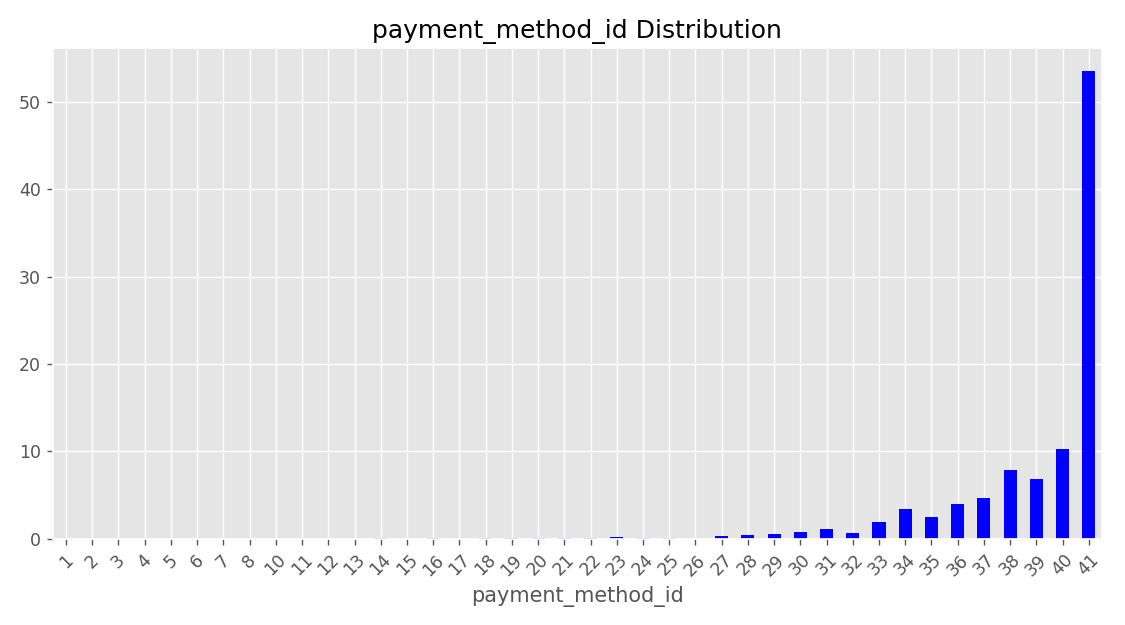

In [90]:
plot_bar(df_transac, ['payment_method_id'])

### Payment Plan in days
There is a lot more variety in subscriptions than I expected
from [KKBOX website](https://help.kkbox.com/hk/zh-tw/billing/pay-types/260), here are the options:
1. Options are monthly plan (30/31 days) with automatic renewal (is_auto_renew true) 
2. Single purchase, no automatic renewal but more expensive:
    3. 30 days
    4. 90 days (plus 7 days bonus?)
    5. 180 days (plus 21 days bonus?)
    6. 365 days (plus 50 days bonus?)
There are discount programs too (getting a credit card with their partners and so on)

0 days doesn't make sense. Because it is low percentage, we can discard it.

We may want to keep only plans shorter than 30/31 days as predicitons are made on a monthly basis.
Indeed, longer subscription means customer will not churn next month

<IPython.core.display.Javascript object>


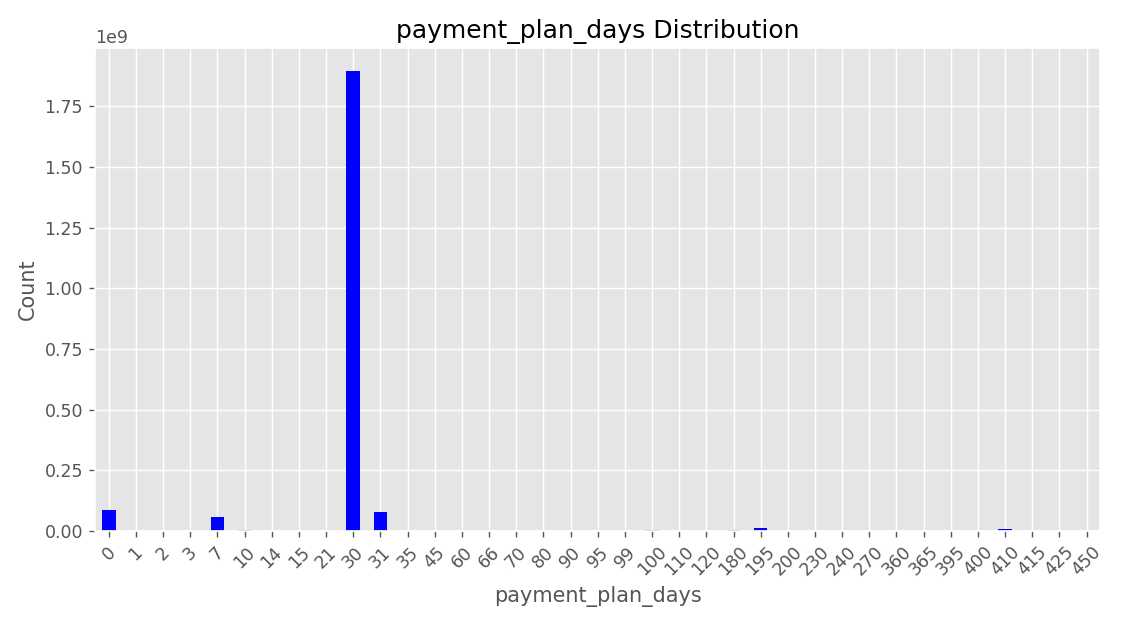

In [7]:
plot_bar(df_transac, ['payment_plan_days'], is_Norm=False)

### A closer look at 0 day plans

Records of 0 day plans also have list price of 0. All other columns appears to contain legitimate information. <br>
Therefore, payment plan days can be inferred by looking at the time difference between expiration date and transaction date. However, when cancellation is active, it will not work as expiration date is not meaningful. In this latter case, we could look at previous transaction from each respective user if needed.

Regarding list prices, we could find the appropriate value based on payment plan days for each year assuming prices change on a yearly basis at most.

Those transactions occur in 2015 except for 3 in 2016 and 1 in 2017.

In [8]:
# select rows where payment plan days are zero
df_zero_day = df_transac[df_transac.payment_plan_days == 0]

In [9]:
df_zero_day.shape

(870124, 8)

In [10]:
# sort by transaction date in ascending order
df_zero_day = df_zero_day.sort_values('transaction_date')

In [11]:
df_zero_day.head(10)

,payment_method_id,payment_plan_days,plan_list_price,actual_amount_paid,is_auto_renew,transaction_date,membership_expire_date,is_cancel
msno,,,,,,,,
YK0mAbVp4I452/awLmy3zqUkO5MoQ+StcsDB1F8nYY4=,1,0,0,0,False,2015-03-08,2015-03-08,True
YK0mAbVp4I452/awLmy3zqUkO5MoQ+StcsDB1F8nYY4=,1,0,0,0,False,2015-03-16,2010-03-25,False
RXvI+ROJZEyU3G/DwrvDRUdVX6qjYe7PGS7x7Xaeu2w=,34,0,0,149,True,2015-03-31,2015-04-30,False
VZ8EjdJwWu7ILguZQYPUXvZw61wXzyowO0CjCyMbT94=,33,0,0,149,True,2015-03-31,2015-04-30,False
w9fT47OkjzP8F5O6dIcicGo/Bem7alQwvfsJqJLK0sE=,31,0,0,149,True,2015-03-31,2015-04-30,False
3OFd7g4b1peE1VsbbVcTS/RHb/30JVNabVCA2US3Qcg=,34,0,0,149,True,2015-03-31,2015-04-30,False
mIRh3NdXqBMYzSOv8TZ3mvW+6Dj5XfGTPvyFyZEMhc8=,33,0,0,149,True,2015-03-31,2015-04-30,False
X+G7dBSIlyCZ2A8KIGYKoM0kh+9yn3/ZfwR9kL2CSiI=,23,0,0,149,True,2015-03-31,2015-04-30,False
txl/2hJxu1aBnlHnpV/MiNLd5aVtxz8ZAwa64oNKk30=,34,0,0,149,True,2015-03-31,2015-04-30,False


In [12]:
df_zero_day.tail(10)

,payment_method_id,payment_plan_days,plan_list_price,actual_amount_paid,is_auto_renew,transaction_date,membership_expire_date,is_cancel
msno,,,,,,,,
/qLjjzshcoXs9AZaZF6QQgjxoYmO/kc5XvYJcIBtHGg=,33,0,0,149,True,2015-10-31,2015-11-30,False
hgnAtuJddAC8xeDLTdH8LgICAVeIpblJ26jmpAlXSWs=,31,0,0,149,True,2015-10-31,2015-11-30,False
qq41P/EMuBb763NCe7Cvj4yI2K6N0uszWJiaXzF65b4=,31,0,0,149,True,2015-10-31,2015-11-30,False
LtfklUks89xRMfmLhX3H4XJ7ETGX+nNhfQKufAUlv0w=,34,0,0,149,True,2015-10-31,2015-11-30,False
dS2WKDR7me3ESNLkoIHA3cuArCWNgiC+fhwbvUt7eY4=,1,0,0,0,False,2015-12-02,2010-03-25,False
yoFSlNP8/d9hoeWusC3OUZMPJLzIOIqaQ53ALlTntf0=,1,0,0,0,False,2015-12-23,2010-03-25,False
YK0mAbVp4I452/awLmy3zqUkO5MoQ+StcsDB1F8nYY4=,1,0,0,0,False,2016-01-21,2016-01-20,True
tGPeF1ZQnR0G8F7cuHvmhkBvnzXFx5eRQ4dV/kY3CfY=,1,0,0,0,False,2016-09-20,2016-09-13,True
bXVpyDYBw/e4k92ZGy8/QGsYPHACPOY3Vs7MT0FF1QA=,1,0,0,0,False,2016-11-28,2016-11-15,True


In [13]:
# check that list prices are also zero
df_zero_day.plan_list_price.sum()

0

#### Replacing 0 payment plan days with no active cancellation

As mentioned above, we need to select plan days equal to zero AND no active cancellation

In [14]:
# boolean filter, no active cancellation and payment plan days is zero
crit_cancel = (df_transac.payment_plan_days == 0) & (df_transac.is_cancel == False)

Here we derive estimated payment plan days from expiration date and transaction date. Expiration date occurs X membership days after transaction by definition. The resulting TimeDelta object is converted to days then to integer (DateTime consists of Year-Month-Day)

In [15]:
# compute payment plan days from transaction date and expiration date
s_rpl = (df_transac.loc[crit_cancel, 'membership_expire_date'] -
             df_transac.loc[crit_cancel, 'transaction_date']).astype('timedelta64[D]').astype('int64')

<IPython.core.display.Javascript object>


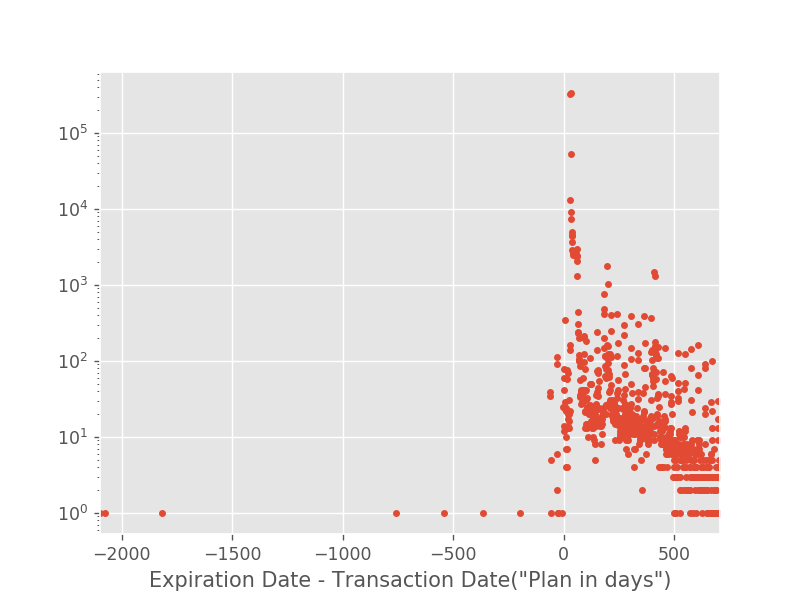

In [16]:
_ , axzeroday = plt.subplots()
s_rpl.value_counts().sort_index().plot(ax = axzeroday, linestyle = 'none', marker ='.')
axzeroday.set_yscale('log')
_ = axzeroday.set_xlabel('Expiration Date - Transaction Date' + '("Plan in days")' )

The last operation created many more values for payment plan days and some values are even negative! <br>
The validity of expiration and transaction dates in those cases is questionable.
<br> Thus we will consider valid only ones that already existed in our data. The others will be discarded.

In [17]:
# list of existing payment plan days
existing_days = df_transac.payment_plan_days.value_counts().index

In [18]:
# add new column corresponding to calculated payment plan days
df_transac['delta_plan_days'] = (df_transac.membership_expire_date -
                                 df_transac.transaction_date).astype('timedelta64[D]').astype('int64')

In [19]:
# update criteria to include only existing plan days 
crit_rpl = crit_cancel & (df_transac.delta_plan_days.isin(existing_days))

# replace selected values
df_transac.loc[crit_rpl , 'payment_plan_days'] = df_transac.loc[crit_rpl , 'delta_plan_days']

In [20]:
print('Number of zeros replaced = {} over {} ({:.2f}%)'.format( crit_rpl.sum(), len(df_zero_day), \
                                                          crit_rpl.sum()/len(df_zero_day)*100))

Number of zeros replaced = 677638 over 870124 (77.88%)


#### Replacing 0 payment plan days WITH active cancellation

In [21]:
# number of zero payment plan days with active cancellation
len(df_zero_day) - crit_cancel.sum()

18162

Select zero payment days where users actively cancelled

In [22]:
crit_cancel_active = (df_transac.payment_plan_days == 0) & (df_transac.is_cancel == True)

In [23]:
df_cancel_active = df_transac[crit_cancel_active]

Select prior transactions when the __same users__ signed up for a plan (no missing values)

In [24]:
crit = (df_transac.payment_plan_days != 0) & (df_transac.is_cancel == False) & (df_transac.index.isin(df_cancel_active.index))

In [25]:
df_signup_history = df_transac[crit]

Combine both dataframe

In [26]:
df_history = pd.concat([df_cancel_active, df_signup_history])

In [27]:
df_GroupedUsers = df_history.groupby('msno', sort=False)

In [45]:
# df_GroupedUsers.size()

In [44]:
df_GroupedUsers.get_group('Ru0DWwS/SJ01Q5H5cHo3ZJh3kuX20FL9nsxiIft7A6Y=').sort_values('transaction_date')

,payment_method_id,payment_plan_days,plan_list_price,actual_amount_paid,is_auto_renew,transaction_date,membership_expire_date,is_cancel,delta_plan_days
msno,,,,,,,,,
Ru0DWwS/SJ01Q5H5cHo3ZJh3kuX20FL9nsxiIft7A6Y=,40,31,149,149,True,2015-01-02,2015-02-01,False,30
Ru0DWwS/SJ01Q5H5cHo3ZJh3kuX20FL9nsxiIft7A6Y=,40,31,149,149,True,2015-02-02,2015-03-01,False,27
Ru0DWwS/SJ01Q5H5cHo3ZJh3kuX20FL9nsxiIft7A6Y=,40,31,149,149,True,2015-03-02,2015-04-01,False,30
Ru0DWwS/SJ01Q5H5cHo3ZJh3kuX20FL9nsxiIft7A6Y=,40,31,149,149,True,2015-04-02,2015-05-01,False,29
Ru0DWwS/SJ01Q5H5cHo3ZJh3kuX20FL9nsxiIft7A6Y=,40,0,0,149,True,2015-05-03,2015-05-01,True,-2
Ru0DWwS/SJ01Q5H5cHo3ZJh3kuX20FL9nsxiIft7A6Y=,36,60,0,150,False,2015-05-05,2015-07-04,False,60
Ru0DWwS/SJ01Q5H5cHo3ZJh3kuX20FL9nsxiIft7A6Y=,36,30,0,150,False,2015-05-05,2015-06-04,False,30
Ru0DWwS/SJ01Q5H5cHo3ZJh3kuX20FL9nsxiIft7A6Y=,36,30,150,150,False,2015-07-08,2015-08-07,False,30
Ru0DWwS/SJ01Q5H5cHo3ZJh3kuX20FL9nsxiIft7A6Y=,36,30,150,150,False,2015-08-06,2015-09-06,False,31


In [31]:
for user_name, user_df in df_GroupedUsers:
    # get transactions from user
    user_df.sort_values('transaction_date')
    
    # replace payment plan days
#     df_transac.loc[user_name, payment_plan_days]

# df_GroupedUsers.groups.keys()

### Auto-renew and active cancellation
People who have auto renewal active also don't cancel actively. It is consitent with the fact that most customers don't churn.

<IPython.core.display.Javascript object>


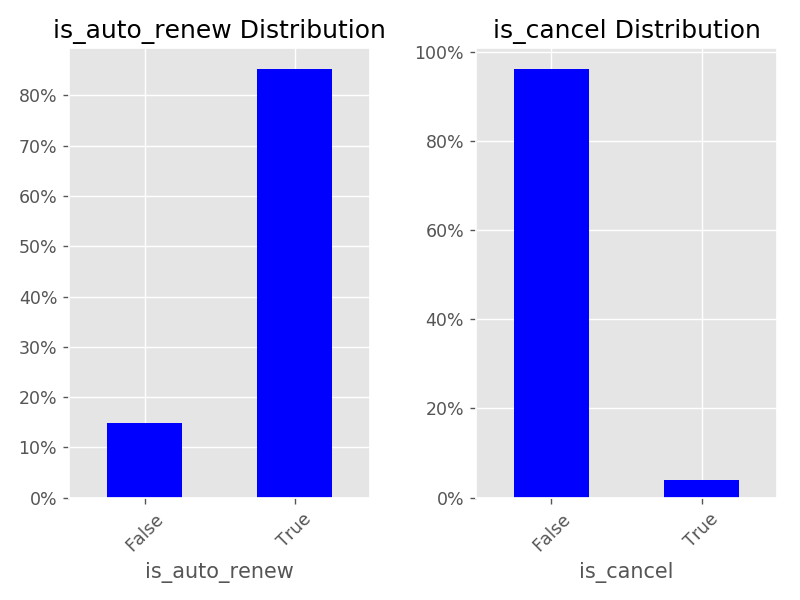

In [9]:
plot_bar(df_transac, ['is_auto_renew' , 'is_cancel'])

### Plan list price
Plan prices are rather discrete therefore there could be categorized for analysis.<br>
Notice some transactions were free probably due to trial period or initial offering. Although, I would expect the actual price paid to be zero. <br>
PS: Plan prices greater than 180 NTD only represents 2% of all transactions.

In [10]:
df_transac.plan_list_price.quantile(q = 0.98)

180.0

<IPython.core.display.Javascript object>


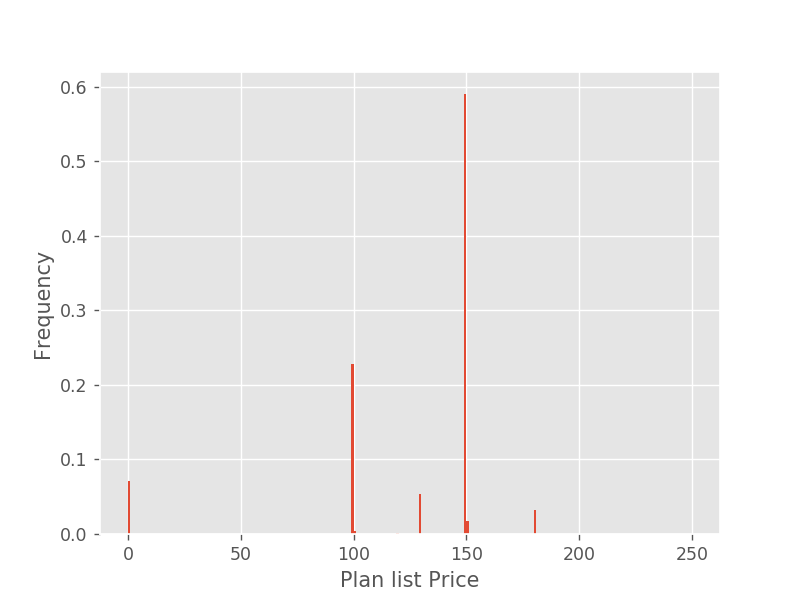

In [11]:
_ , axListPrice = plt.subplots()
_ = df_transac.plan_list_price.plot(kind = 'hist', \
                                bins = 250, range = (0,250), density = True,\
                                ax = axListPrice)
_ = axListPrice.set_xlabel('Plan list Price')

### Subscription cost per subscription length
How do subscription length scale with list price ? <br>
First, let's group plan duration by the following intervals in days:
| 0 - 7 | 8 - 29 | 30 - 89 | 90 - 179 | 180 - 364  | 365 - 450 |


In [91]:
# create custom intervals (bin edges will be left inclusive) in increasing order
days_plan = [0, 8, 30, 90, 180, 365, 451 ]

# compile labels
days_plan_upperbounds = [d-1 for d in days_plan[1:-1] ]
days_plan_upperbounds.append(days_plan[-1])
days_plan_labels = [ "{} - {}".format(l,u) for l,u in zip(days_plan[:-1], days_plan_upperbounds) ]

print('Bin edges = {}'.format(days_plan))
print('Associated labels = {}'.format(days_plan_labels))

Bin edges = [0, 8, 30, 90, 180, 365, 451]
Associated labels = ['0 - 7', '8 - 29', '30 - 89', '90 - 179', '180 - 364', '365 - 451']


In [92]:
# create new column with plan duration category
df_transac['plan_duration'] = pd.cut(df_transac.payment_plan_days, days_plan, right=False, labels=days_plan_labels)

Create bar plot for each auto renew state (True or False) and observe the list price going up with subscription length globally.<br> Free subscription are available across all subscription length.

<IPython.core.display.Javascript object>


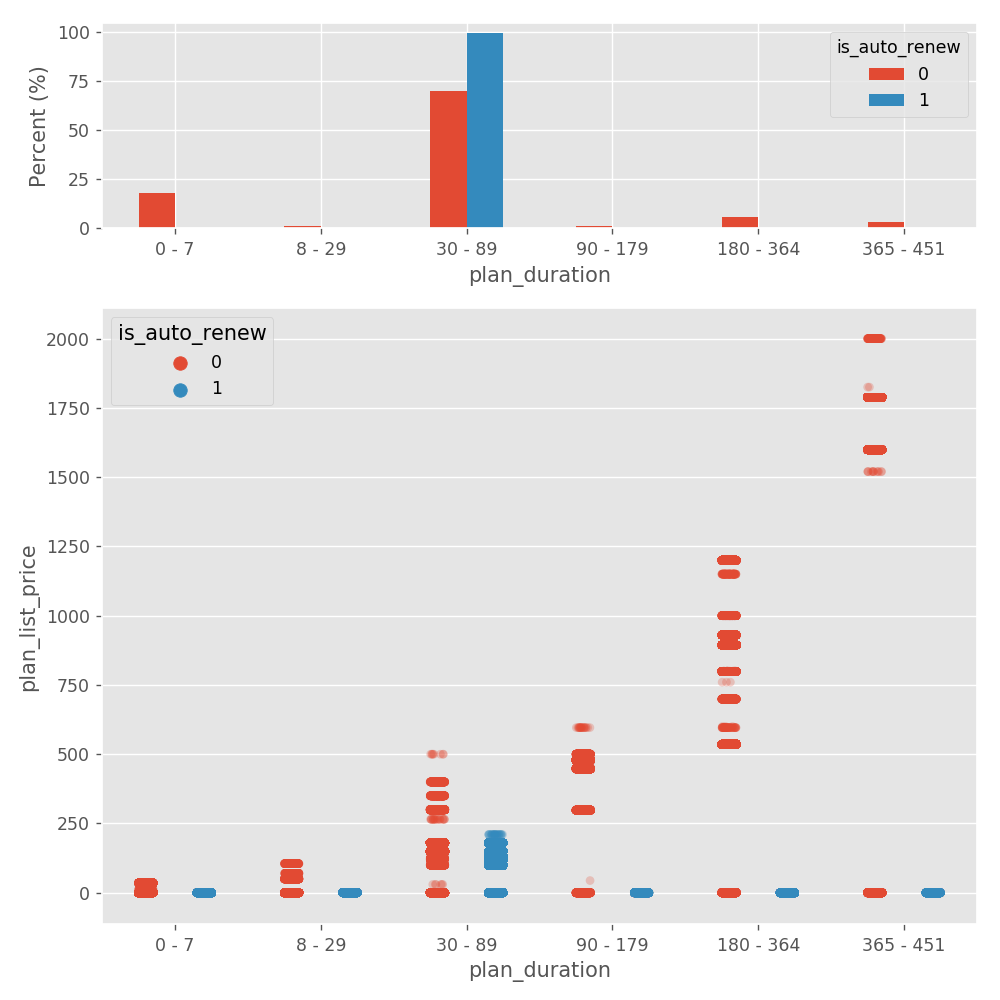

In [94]:
# prepare axis
_ , axCostDays = plt.subplots(2, 1, \
                              figsize=(8, 8), \
                              gridspec_kw=dict(height_ratios=[1, 3]))

# pivot on relevant columns, values can be anything as we are just counting here
df_plan = df_transac.pivot_table(index = 'plan_duration', columns = 'is_auto_renew',\
                                 values = 'plan_list_price', aggfunc = 'count', fill_value = 0)

# normalize each column by counts
df_plan = df_plan.divide(df_plan.sum()) * 100

# make a bar plot for each auto renew state
df_plan.plot(kind = 'bar', ax = axCostDays[0])

# change tick orientation and add labels
axCostDays[0].tick_params(axis = 'x', rotation = 0)
axCostDays[0].set_ylabel('Percent (%)')
axCostDays[0].set_xlabel('plan_duration')


# use seaborn to add plan list price as another dimension
sns.stripplot(x="plan_duration", y="plan_list_price", hue = 'is_auto_renew',\
              dodge = True, jitter = True, alpha = 0.25,\
              data=df_transac, ax = axCostDays[1])
# sns.swarmplot(x="plan_duration", y="plan_list_price", hue = 'is_auto_renew',\
#               dodge = True, alpha = 0.25,\
#               data=df_transac, ax = axCostDays[1])

plt.tight_layout()

The Empirical cumulative distribution function (ECDF) can give us another view when there are too many points to plot.

<IPython.core.display.Javascript object>


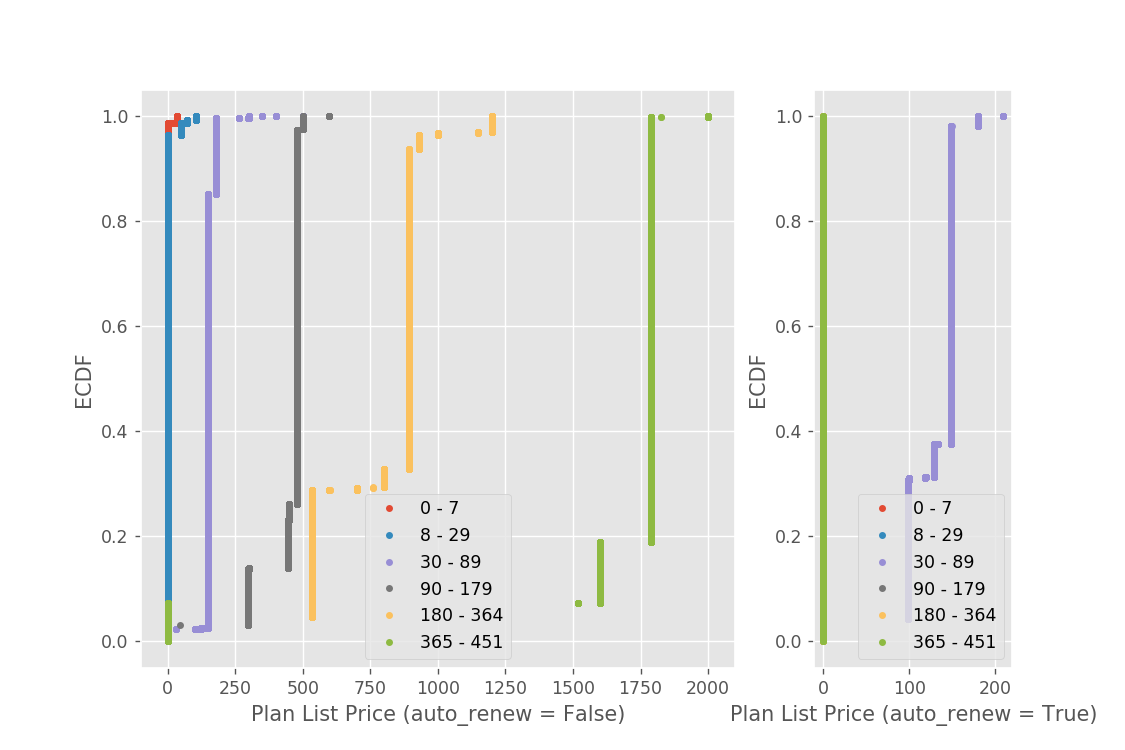

In [93]:
_ , axEcdf = plt.subplots(1, 2, figsize=(9, 6), gridspec_kw=dict(width_ratios=[3, 1]))

for i in range(2):
    # sort your data and plot it versus its percentage increment
    for pl in days_plan_labels:
        filt_pl = (df_transac.is_auto_renew == i ) & (df_transac.plan_duration == pl)
        pl_x = df_transac.loc[filt_pl, 'plan_list_price'].sort_values().values
        pl_y = np.arange(1, len(pl_x)+1) / len(pl_x)
        axEcdf[i].plot(pl_x, pl_y, '.')
        axEcdf[i].set_xlabel('Plan List Price (auto_renew = ' + str(bool(i)) + ')'  )
        axEcdf[i].set_ylabel('ECDF')
    axEcdf[i].legend(days_plan_labels)

### List price vs paid price
If we compile the percent discount between actual amount and list price (assuming actual amount is always lower or equal to list price), some value will be infinity between we would divide by 0 (when x->0 (1/x)->Inf) <br>
So we should filter out those events that represents ~ 7.5% of all transactions.

In [21]:
df_discount = df_transac[~(df_transac.plan_list_price == 0)]

In [22]:
# percent difference between plan price and price actually paid
discount_percent = 1 - (df_discount.actual_amount_paid/df_discount.plan_list_price)

It appears that an overwhelming majority of transcations do not have any discount (more than 95%).<br>
Note: bin width is 0.1 thus normalization is multiplied by 10 (divided by 0.1). It means 100% corresponds to 10 on the y scale.

<IPython.core.display.Javascript object>


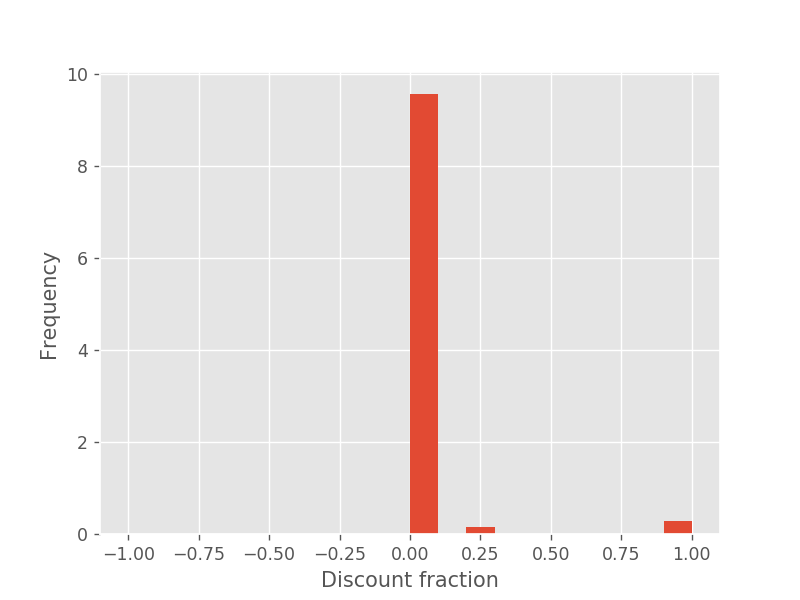

In [23]:
# plot histogram of discounts
_ , axDiscount = plt.subplots()

# plot histogram, bin by 10% intervals
_ = discount_percent.plot(kind = 'hist', range = (-1,1), bins = 20, ax = axDiscount, density = True)

_ = axDiscount.set_xlabel('Discount fraction')

### Transaction and expiration dates
Transactions start in January 2015 up to February 2017. <br>
Membership expiration date takes into account the result of this transaction. For instance, a user who signs up for 2 months will have a membership expiration date 2 months after transaction date. In constrast, a user who actively cancels his plan is recorded as a transaction where expiration date is typically the day after transaction date.

In [69]:
df_transac.transaction_date.describe()

count                21547746
unique                    790
top       2016-08-31 00:00:00
freq                   203688
first     2015-01-01 00:00:00
last      2017-02-28 00:00:00
Name: transaction_date, dtype: object

In [70]:
# compute difference in time between expiration date and transaction date
deltaTransacDate = df_transac.membership_expire_date - df_transac.transaction_date

# convert timedelta to days (it will produce integer)
deltaTransacDate = deltaTransacDate.astype('timedelta64[D]')

# convert timedelta object to days (keep decimals)
# deltaTransacDate = deltaTransacDate/pd.Timedelta('1 day')
# deltaTransacDate = deltaTransacDate/np.timedelta64(1, 'D')

Without surprise, most people renew their membership for 30 or 31 days (Most popular plan). There are other smaller peaks at 0 day, 60 days and 90 days. Users who actively cancels is represented by the 0 day peak.

<IPython.core.display.Javascript object>


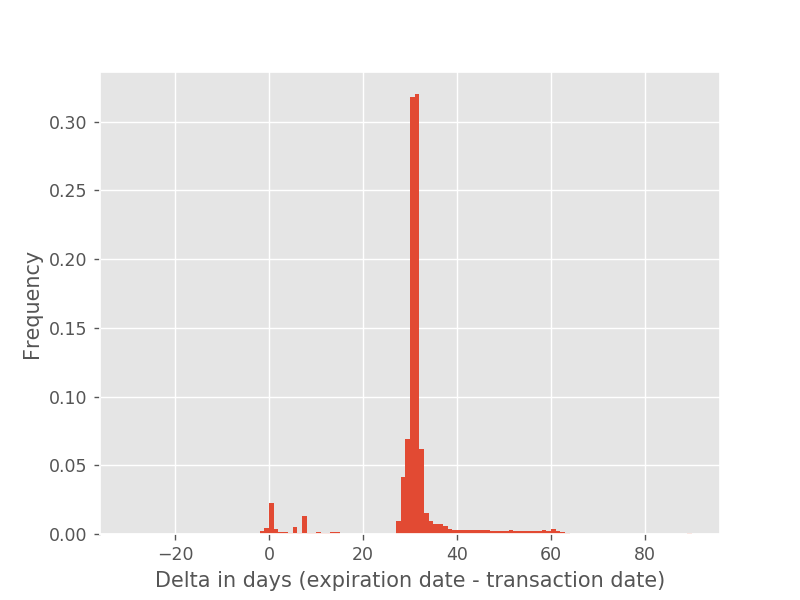

In [71]:
# histogram days, matplotlib hist composes bin with right edge excluded EXCEPT for the last bin
_ , axTransacDate = plt.subplots()

_ = deltaTransacDate.plot(kind = 'hist', range= (-30, 90), bins = 120, density = True, ax = axTransacDate)

_ = axTransacDate.set_xlabel('Delta in days (expiration date - transaction date)')

# NOTE: there are some unrealistic out of range values like -17599 days